In [1]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"

OUT_DIR   = "./ConvNeXt_V2_output"

EPOCHS    = 100
BATCH     = 32
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"   

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt_V2_output
EPOCHS/BATCH/LR: 100 32 0.0002
VAL_RATIO/SAMPLER: 0.2 off


In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


In [4]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y

Missing files — Train: 0 | Test: 0


In [5]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

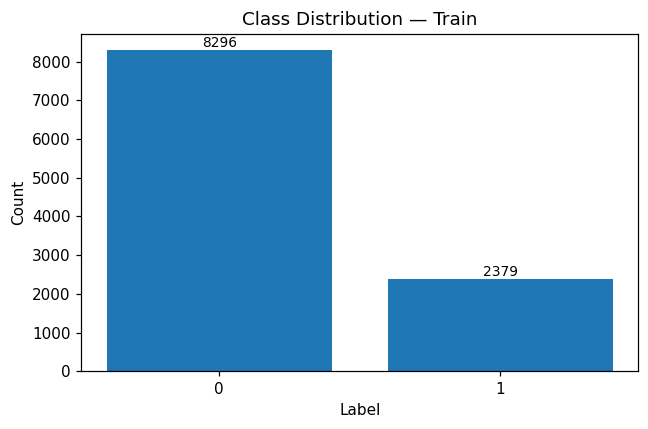

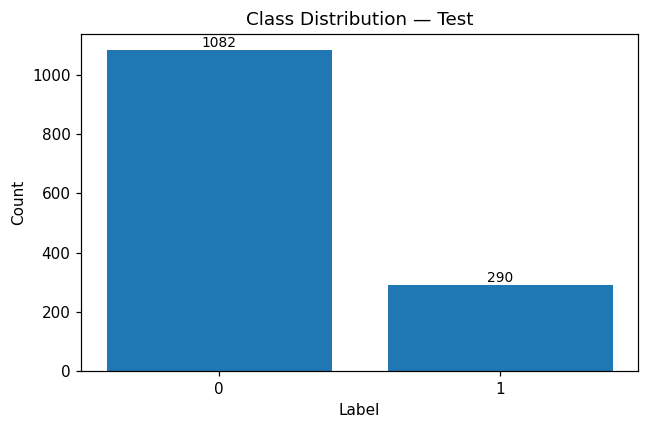

[Train] Missing: 0/10675 — saved to ./ConvNeXt_V2_output\eda\missing_train.txt
[Test] Missing: 0/1372 — saved to ./ConvNeXt_V2_output\eda\missing_test.txt


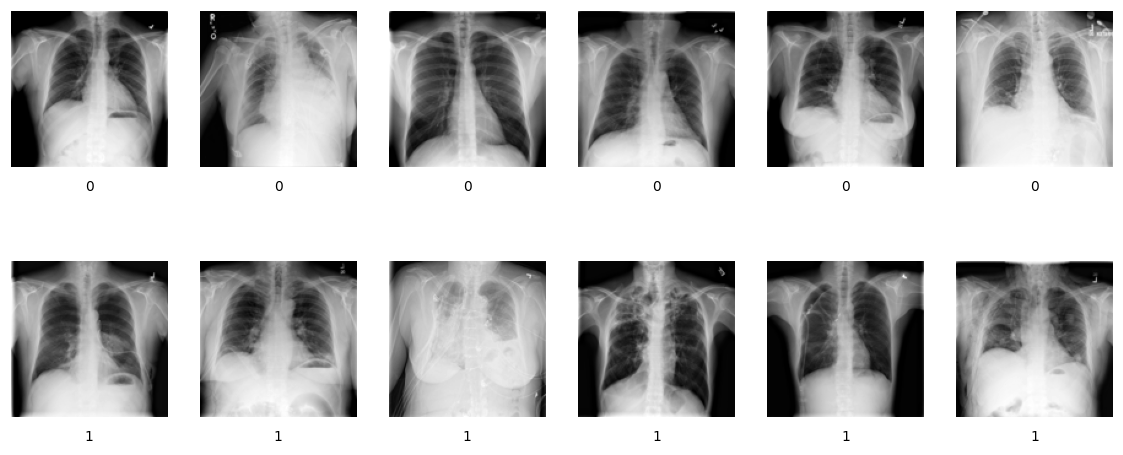

In [6]:
from pathlib import Path

eda_class_distribution(train_df, "has_pneumo", os.path.join(EDA_DIR, "class_dist_train.png"), "Train")
eda_class_distribution(test_df,  "has_pneumo", os.path.join(EDA_DIR, "class_dist_test.png"),  "Test")

eda_missing_files(train_df, os.path.join(EDA_DIR, "missing_train.txt"), "Train")
eda_missing_files(test_df,  os.path.join(EDA_DIR, "missing_test.txt"),  "Test")

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [7]:
# Stratified split
tr_df, val_df = train_test_split(train_df, test_size=VAL_RATIO,
                                 stratify=train_df["has_pneumo"], random_state=SEED)

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Datasets
ds_train = PandasImageDataset(tr_df, transform=train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)

if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

len(ds_train), len(ds_val), len(ds_test)

(8540, 2135, 1372)

# ConvNeXt_V2
## DropPath (Random Depth)

In [8]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    """按样本丢弃整个 residual branch，做 Stochastic Depth。"""
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # 只在 batch 维度采样，其它维度广播
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # 变成 0/1
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [9]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [10]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [11]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  # ConvNeXt V2 中一般设为 0（等价于去掉 LayerScale）
    ):
        super().__init__()
        # 7x7 深度可分离卷积
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # 在 channels_last 格式上做 LayerNorm
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale（V2 通常设为 0，即关闭）
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## ConvNeXt_V2 tiny

In [12]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0,  # V2: 一般设 0
    ):
        super().__init__()

        # 4 个 stage 的深度和通道配置（与官方 ConvNeXt V2 Tiny 一致）
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # ---- stem：patch embedding，stride=4，下采样一次 ----
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # ---- 为每个 stage 构建 blocks 与下采样层 ----
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # 从第二个 stage 开始，每个 stage 前面有一个 2x2 下采样
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # 最后的分类头：LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # 依次下采样 + 各个 stage
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # 全局平均池化到 [N, C]
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()
        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,  # ConvNeXt V2 关键：去掉 LayerScale
        )

    def forward(self, x):
        # self.backbone 输出 [B, 1]，为了兼容你之前的代码，挤掉 channel 维度
        logits = self.backbone(x)  # [B, 1]
        return logits.squeeze(1)   # [B]
    
model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

In [13]:
# pos = (np.array(tr_df["has_pneumo"])==1).sum()
# neg = (np.array(tr_df["has_pneumo"])==0).sum()
# pos_weight = torch.tensor([neg / max(pos,1)], device=device, dtype=torch.float32)

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# print("pos/neg:", pos, neg, "| pos_weight:", pos_weight.item())

# 使用 Focal Loss 代替 BCEWithLogitsLoss 来处理类不平衡

# 1) 统计正负样本数量
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

# 给“有 pneumothorax（正类=1）”一个 alpha 权重，这里按样本数自适应
alpha = neg / (pos + neg + 1e-8)   # alpha ∈ (0,1)，正类的权重

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# 2) 定义二分类 Focal Loss（logits 输入）
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits:  [B] 或 [B, 1]
        targets: [B] 或 [B, 1]，取值为 0/1
        """
        # 形状对齐
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # 概率与 p_t
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # 按类别加权的 alpha_t
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal 权重
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # 基础 BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# 3) 创建损失、优化器和 scheduler
criterion = BinaryFocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=1903, neg=6637, alpha=0.7772


C:\Users\Steven\AppData\Local\Temp\ipykernel_67376\2831803700.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [14]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)             # [B]
        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    # 基本指标（0~1）
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    # 只使用 1..best_epoch 的记录
    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0  # 转成百分比看起来更直观

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

In [15]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS+1):
    model.train()
    running, nb = 0.0, 0
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb in dl_train:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        
        # 混合精度训练
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(xb)             # [B]
            loss = criterion(logits, yb)   # BCEWithLogitsLoss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        running += loss.item()
        nb += 1
      
        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]
        bar.set_postfix(loss=f"{running/max(nb,1):.4f}", lr=f"{curr_lr:.2e}")
        bar.update(1)
    scheduler.step() 
    bar.close()

    # -------- 1) 计算本 epoch 的 train_loss --------
    train_loss_epoch = running / max(nb, 1)
    
    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()
            logits = model(xb)
            loss_val = criterion(logits, yb)
            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    # 2.2 再用你改好的 evaluate 统一算指标（acc/prec/rec/f1/spec/roc/pr）
    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    # -------- 3) 记录历史，后面画 learning curve 用 --------
    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    # -------- 4) Early stopping 逻辑（不变） --------
    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# -------- 5) 还原 best 权重并保存 --------
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 01/100 train_loss=0.0779 val_loss=0.0644 val_acc=0.2230 val_prec=0.2230 val_rec=1.0000 val_f1=0.3646 val_spec=0.0000 val_roc=0.6102 val_pr=0.2958 | val_pr_auc=0.2958 best_pr_auc=0.2958 (epoch 1)


Epoch 2/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 02/100 train_loss=0.0611 val_loss=0.0605 val_acc=0.7747 val_prec=0.0000 val_rec=0.0000 val_f1=0.0000 val_spec=0.9970 val_roc=0.6299 val_pr=0.2939 | val_pr_auc=0.2939 best_pr_auc=0.2958 (epoch 1)


Epoch 3/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 03/100 train_loss=0.0599 val_loss=0.0623 val_acc=0.2876 val_prec=0.2349 val_rec=0.9727 val_f1=0.3784 val_spec=0.0910 val_roc=0.6377 val_pr=0.2997 | val_pr_auc=0.2997 best_pr_auc=0.2997 (epoch 3)


Epoch 4/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 04/100 train_loss=0.0587 val_loss=0.0583 val_acc=0.5016 val_prec=0.2812 val_rec=0.7941 val_f1=0.4154 val_spec=0.4177 val_roc=0.6456 val_pr=0.3076 | val_pr_auc=0.3076 best_pr_auc=0.3076 (epoch 4)


Epoch 5/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 05/100 train_loss=0.0589 val_loss=0.0574 val_acc=0.6173 val_prec=0.3149 val_rec=0.6092 val_f1=0.4152 val_spec=0.6197 val_roc=0.6515 val_pr=0.3233 | val_pr_auc=0.3233 best_pr_auc=0.3233 (epoch 5)


Epoch 6/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 06/100 train_loss=0.0582 val_loss=0.0570 val_acc=0.6637 val_prec=0.3374 val_rec=0.5273 val_f1=0.4115 val_spec=0.7028 val_roc=0.6638 val_pr=0.3322 | val_pr_auc=0.3322 best_pr_auc=0.3322 (epoch 6)


Epoch 7/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 07/100 train_loss=0.0576 val_loss=0.0560 val_acc=0.6403 val_prec=0.3356 val_rec=0.6261 val_f1=0.4370 val_spec=0.6444 val_roc=0.6784 val_pr=0.3531 | val_pr_auc=0.3531 best_pr_auc=0.3531 (epoch 7)


Epoch 8/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 08/100 train_loss=0.0564 val_loss=0.0549 val_acc=0.6014 val_prec=0.3262 val_rec=0.7395 val_f1=0.4527 val_spec=0.5618 val_roc=0.7029 val_pr=0.3971 | val_pr_auc=0.3971 best_pr_auc=0.3971 (epoch 8)


Epoch 9/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 09/100 train_loss=0.0556 val_loss=0.0564 val_acc=0.7349 val_prec=0.4062 val_rec=0.4097 val_f1=0.4079 val_spec=0.8282 val_roc=0.7100 val_pr=0.3905 | val_pr_auc=0.3905 best_pr_auc=0.3971 (epoch 8)


Epoch 10/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10/100 train_loss=0.0550 val_loss=0.0551 val_acc=0.5494 val_prec=0.3096 val_rec=0.8298 val_f1=0.4509 val_spec=0.4690 val_roc=0.7181 val_pr=0.4256 | val_pr_auc=0.4256 best_pr_auc=0.4256 (epoch 10)


Epoch 11/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11/100 train_loss=0.0535 val_loss=0.0514 val_acc=0.6637 val_prec=0.3729 val_rec=0.7458 val_f1=0.4972 val_spec=0.6401 val_roc=0.7547 val_pr=0.4488 | val_pr_auc=0.4488 best_pr_auc=0.4488 (epoch 11)


Epoch 12/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12/100 train_loss=0.0528 val_loss=0.0522 val_acc=0.6178 val_prec=0.3466 val_rec=0.8067 val_f1=0.4848 val_spec=0.5636 val_roc=0.7518 val_pr=0.4623 | val_pr_auc=0.4623 best_pr_auc=0.4623 (epoch 12)


Epoch 13/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 13/100 train_loss=0.0522 val_loss=0.0514 val_acc=0.7194 val_prec=0.4172 val_rec=0.6513 val_f1=0.5086 val_spec=0.7390 val_roc=0.7615 val_pr=0.4710 | val_pr_auc=0.4710 best_pr_auc=0.4710 (epoch 13)


Epoch 14/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 14/100 train_loss=0.0507 val_loss=0.0506 val_acc=0.6674 val_prec=0.3781 val_rec=0.7626 val_f1=0.5056 val_spec=0.6401 val_roc=0.7738 val_pr=0.4721 | val_pr_auc=0.4721 best_pr_auc=0.4721 (epoch 14)


Epoch 15/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 15/100 train_loss=0.0504 val_loss=0.0515 val_acc=0.7485 val_prec=0.4501 val_rec=0.5777 val_f1=0.5060 val_spec=0.7975 val_roc=0.7786 val_pr=0.4952 | val_pr_auc=0.4952 best_pr_auc=0.4952 (epoch 15)


Epoch 16/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 16/100 train_loss=0.0497 val_loss=0.0483 val_acc=0.6927 val_prec=0.4028 val_rec=0.7836 val_f1=0.5321 val_spec=0.6667 val_roc=0.7986 val_pr=0.5284 | val_pr_auc=0.5284 best_pr_auc=0.5284 (epoch 16)


Epoch 17/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 17/100 train_loss=0.0485 val_loss=0.0489 val_acc=0.7710 val_prec=0.4899 val_rec=0.6597 val_f1=0.5622 val_spec=0.8029 val_roc=0.8042 val_pr=0.5311 | val_pr_auc=0.5311 best_pr_auc=0.5311 (epoch 17)


Epoch 18/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 18/100 train_loss=0.0478 val_loss=0.0481 val_acc=0.6946 val_prec=0.4085 val_rec=0.8256 val_f1=0.5466 val_spec=0.6570 val_roc=0.8031 val_pr=0.5251 | val_pr_auc=0.5251 best_pr_auc=0.5311 (epoch 17)


Epoch 19/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 19/100 train_loss=0.0470 val_loss=0.0478 val_acc=0.7761 val_prec=0.4985 val_rec=0.6765 val_f1=0.5740 val_spec=0.8047 val_roc=0.8105 val_pr=0.5529 | val_pr_auc=0.5529 best_pr_auc=0.5529 (epoch 19)


Epoch 20/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 20/100 train_loss=0.0463 val_loss=0.0492 val_acc=0.6351 val_prec=0.3681 val_rec=0.8887 val_f1=0.5206 val_spec=0.5624 val_roc=0.8195 val_pr=0.5423 | val_pr_auc=0.5423 best_pr_auc=0.5529 (epoch 19)


Epoch 21/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 21/100 train_loss=0.0457 val_loss=0.0457 val_acc=0.7452 val_prec=0.4574 val_rec=0.7668 val_f1=0.5730 val_spec=0.7390 val_roc=0.8316 val_pr=0.5773 | val_pr_auc=0.5773 best_pr_auc=0.5773 (epoch 21)


Epoch 22/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 22/100 train_loss=0.0448 val_loss=0.0473 val_acc=0.7836 val_prec=0.5117 val_rec=0.6429 val_f1=0.5698 val_spec=0.8240 val_roc=0.8220 val_pr=0.5573 | val_pr_auc=0.5573 best_pr_auc=0.5773 (epoch 21)


Epoch 23/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 23/100 train_loss=0.0444 val_loss=0.0451 val_acc=0.7569 val_prec=0.4723 val_rec=0.7689 val_f1=0.5851 val_spec=0.7535 val_roc=0.8317 val_pr=0.5755 | val_pr_auc=0.5755 best_pr_auc=0.5773 (epoch 21)


Epoch 24/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 24/100 train_loss=0.0438 val_loss=0.0451 val_acc=0.7705 val_prec=0.4903 val_rec=0.7437 val_f1=0.5910 val_spec=0.7782 val_roc=0.8345 val_pr=0.5908 | val_pr_auc=0.5908 best_pr_auc=0.5908 (epoch 24)


Epoch 25/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 25/100 train_loss=0.0427 val_loss=0.0460 val_acc=0.7635 val_prec=0.4800 val_rec=0.7311 val_f1=0.5795 val_spec=0.7728 val_roc=0.8308 val_pr=0.5831 | val_pr_auc=0.5831 best_pr_auc=0.5908 (epoch 24)


Epoch 26/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 26/100 train_loss=0.0423 val_loss=0.0489 val_acc=0.7803 val_prec=0.5060 val_rec=0.6155 val_f1=0.5555 val_spec=0.8276 val_roc=0.8229 val_pr=0.5773 | val_pr_auc=0.5773 best_pr_auc=0.5908 (epoch 24)


Epoch 27/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 27/100 train_loss=0.0411 val_loss=0.0458 val_acc=0.7518 val_prec=0.4655 val_rec=0.7647 val_f1=0.5787 val_spec=0.7480 val_roc=0.8293 val_pr=0.5797 | val_pr_auc=0.5797 best_pr_auc=0.5908 (epoch 24)


Epoch 28/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 28/100 train_loss=0.0411 val_loss=0.0461 val_acc=0.7691 val_prec=0.4879 val_rec=0.7185 val_f1=0.5811 val_spec=0.7836 val_roc=0.8325 val_pr=0.5827 | val_pr_auc=0.5827 best_pr_auc=0.5908 (epoch 24)


Epoch 29/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 29/100 train_loss=0.0401 val_loss=0.0483 val_acc=0.7817 val_prec=0.5081 val_rec=0.6555 val_f1=0.5725 val_spec=0.8180 val_roc=0.8288 val_pr=0.5780 | val_pr_auc=0.5780 best_pr_auc=0.5908 (epoch 24)


Epoch 30/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 30/100 train_loss=0.0394 val_loss=0.0470 val_acc=0.7803 val_prec=0.5054 val_rec=0.6870 val_f1=0.5824 val_spec=0.8071 val_roc=0.8322 val_pr=0.5905 | val_pr_auc=0.5905 best_pr_auc=0.5908 (epoch 24)


Epoch 31/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 31/100 train_loss=0.0390 val_loss=0.0458 val_acc=0.7635 val_prec=0.4808 val_rec=0.7647 val_f1=0.5904 val_spec=0.7631 val_roc=0.8384 val_pr=0.5803 | val_pr_auc=0.5803 best_pr_auc=0.5908 (epoch 24)


Epoch 32/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 32/100 train_loss=0.0374 val_loss=0.0462 val_acc=0.7813 val_prec=0.5062 val_rec=0.7668 val_f1=0.6099 val_spec=0.7854 val_roc=0.8491 val_pr=0.6152 | val_pr_auc=0.6152 best_pr_auc=0.6152 (epoch 32)


Epoch 33/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 33/100 train_loss=0.0364 val_loss=0.0488 val_acc=0.7218 val_prec=0.4303 val_rec=0.7647 val_f1=0.5507 val_spec=0.7095 val_roc=0.8148 val_pr=0.5495 | val_pr_auc=0.5495 best_pr_auc=0.6152 (epoch 32)


Epoch 34/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 34/100 train_loss=0.0360 val_loss=0.0477 val_acc=0.7574 val_prec=0.4719 val_rec=0.7416 val_f1=0.5768 val_spec=0.7619 val_roc=0.8314 val_pr=0.5787 | val_pr_auc=0.5787 best_pr_auc=0.6152 (epoch 32)


Epoch 35/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 35/100 train_loss=0.0349 val_loss=0.0444 val_acc=0.7574 val_prec=0.4741 val_rec=0.8067 val_f1=0.5972 val_spec=0.7432 val_roc=0.8480 val_pr=0.6026 | val_pr_auc=0.6026 best_pr_auc=0.6152 (epoch 32)


Epoch 36/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 36/100 train_loss=0.0344 val_loss=0.0447 val_acc=0.7429 val_prec=0.4567 val_rec=0.8088 val_f1=0.5838 val_spec=0.7239 val_roc=0.8422 val_pr=0.5878 | val_pr_auc=0.5878 best_pr_auc=0.6152 (epoch 32)


Epoch 37/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 37/100 train_loss=0.0334 val_loss=0.0457 val_acc=0.7358 val_prec=0.4487 val_rec=0.8088 val_f1=0.5772 val_spec=0.7149 val_roc=0.8426 val_pr=0.5930 | val_pr_auc=0.5930 best_pr_auc=0.6152 (epoch 32)


Epoch 38/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 38/100 train_loss=0.0324 val_loss=0.0508 val_acc=0.7775 val_prec=0.5008 val_rec=0.6975 val_f1=0.5830 val_spec=0.8005 val_roc=0.8401 val_pr=0.5968 | val_pr_auc=0.5968 best_pr_auc=0.6152 (epoch 32)


Epoch 39/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 39/100 train_loss=0.0304 val_loss=0.0495 val_acc=0.7639 val_prec=0.4815 val_rec=0.7647 val_f1=0.5909 val_spec=0.7637 val_roc=0.8419 val_pr=0.6012 | val_pr_auc=0.6012 best_pr_auc=0.6152 (epoch 32)


Epoch 40/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 40/100 train_loss=0.0306 val_loss=0.0489 val_acc=0.7733 val_prec=0.4945 val_rec=0.7500 val_f1=0.5960 val_spec=0.7800 val_roc=0.8452 val_pr=0.6176 | val_pr_auc=0.6176 best_pr_auc=0.6176 (epoch 40)


Epoch 41/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 41/100 train_loss=0.0295 val_loss=0.0563 val_acc=0.7658 val_prec=0.4831 val_rec=0.7206 val_f1=0.5784 val_spec=0.7788 val_roc=0.8342 val_pr=0.5952 | val_pr_auc=0.5952 best_pr_auc=0.6176 (epoch 40)


Epoch 42/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 42/100 train_loss=0.0281 val_loss=0.0549 val_acc=0.8098 val_prec=0.5587 val_rec=0.6996 val_f1=0.6213 val_spec=0.8415 val_roc=0.8522 val_pr=0.6164 | val_pr_auc=0.6164 best_pr_auc=0.6176 (epoch 40)


Epoch 43/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 43/100 train_loss=0.0269 val_loss=0.0613 val_acc=0.7925 val_prec=0.5261 val_rec=0.6975 val_f1=0.5998 val_spec=0.8198 val_roc=0.8405 val_pr=0.5950 | val_pr_auc=0.5950 best_pr_auc=0.6176 (epoch 40)


Epoch 44/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 44/100 train_loss=0.0258 val_loss=0.0700 val_acc=0.8070 val_prec=0.5590 val_rec=0.6366 val_f1=0.5953 val_spec=0.8559 val_roc=0.8321 val_pr=0.5861 | val_pr_auc=0.5861 best_pr_auc=0.6176 (epoch 40)


Epoch 45/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 45/100 train_loss=0.0257 val_loss=0.0512 val_acc=0.7518 val_prec=0.4667 val_rec=0.7962 val_f1=0.5885 val_spec=0.7390 val_roc=0.8438 val_pr=0.6004 | val_pr_auc=0.6004 best_pr_auc=0.6176 (epoch 40)


Epoch 46/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 46/100 train_loss=0.0241 val_loss=0.0662 val_acc=0.8169 val_prec=0.5777 val_rec=0.6639 val_f1=0.6178 val_spec=0.8608 val_roc=0.8503 val_pr=0.6305 | val_pr_auc=0.6305 best_pr_auc=0.6305 (epoch 46)


Epoch 47/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 47/100 train_loss=0.0239 val_loss=0.0731 val_acc=0.8112 val_prec=0.5658 val_rec=0.6597 val_f1=0.6091 val_spec=0.8547 val_roc=0.8421 val_pr=0.6086 | val_pr_auc=0.6086 best_pr_auc=0.6305 (epoch 46)


Epoch 48/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 48/100 train_loss=0.0218 val_loss=0.0722 val_acc=0.7958 val_prec=0.5324 val_rec=0.6912 val_f1=0.6015 val_spec=0.8258 val_roc=0.8436 val_pr=0.6072 | val_pr_auc=0.6072 best_pr_auc=0.6305 (epoch 46)


Epoch 49/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 49/100 train_loss=0.0213 val_loss=0.0623 val_acc=0.7916 val_prec=0.5250 val_rec=0.6828 val_f1=0.5936 val_spec=0.8228 val_roc=0.8424 val_pr=0.6007 | val_pr_auc=0.6007 best_pr_auc=0.6305 (epoch 46)


Epoch 50/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 50/100 train_loss=0.0207 val_loss=0.0892 val_acc=0.8080 val_prec=0.5635 val_rec=0.6155 val_f1=0.5884 val_spec=0.8632 val_roc=0.8314 val_pr=0.5988 | val_pr_auc=0.5988 best_pr_auc=0.6305 (epoch 46)


Epoch 51/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 51/100 train_loss=0.0197 val_loss=0.1023 val_acc=0.7930 val_prec=0.5285 val_rec=0.6618 val_f1=0.5877 val_spec=0.8306 val_roc=0.8272 val_pr=0.5889 | val_pr_auc=0.5889 best_pr_auc=0.6305 (epoch 46)


Epoch 52/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 52/100 train_loss=0.0189 val_loss=0.0808 val_acc=0.8000 val_prec=0.5465 val_rec=0.6050 val_f1=0.5743 val_spec=0.8559 val_roc=0.8376 val_pr=0.5943 | val_pr_auc=0.5943 best_pr_auc=0.6305 (epoch 46)


Epoch 53/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 53/100 train_loss=0.0170 val_loss=0.0845 val_acc=0.8117 val_prec=0.5712 val_rec=0.6239 val_f1=0.5964 val_spec=0.8656 val_roc=0.8452 val_pr=0.6128 | val_pr_auc=0.6128 best_pr_auc=0.6305 (epoch 46)


Epoch 54/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 54/100 train_loss=0.0168 val_loss=0.0833 val_acc=0.8131 val_prec=0.5706 val_rec=0.6534 val_f1=0.6092 val_spec=0.8590 val_roc=0.8449 val_pr=0.5932 | val_pr_auc=0.5932 best_pr_auc=0.6305 (epoch 46)
[EarlyStop] Stop at epoch 54. Best pr_auc=0.6305 @ epoch 46.



[Best model @ Val]
Accuracy (%)        : 81.686
Precision (%)       : 57.77
Recall (%)          : 66.387
F1-Score (%)        : 61.779
Specificity (%)     : 86.076
ROC-AUC (%)         : 85.035
Precision-recall (%): 63.045

[Best model @ Test]
Accuracy (%)        : 81.414
Precision (%)       : 54.986
Recall (%)          : 66.552
F1-Score (%)        : 60.218
Specificity (%)     : 85.397
ROC-AUC (%)         : 84.82
Precision-recall (%): 57.985


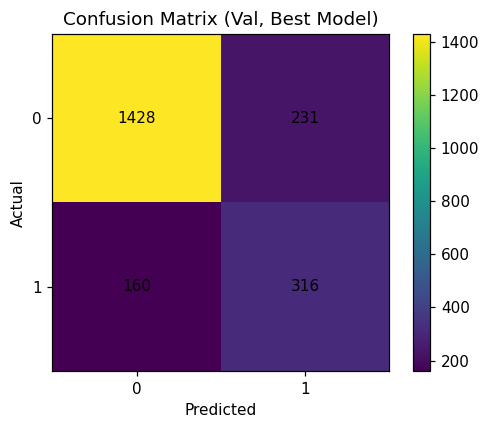

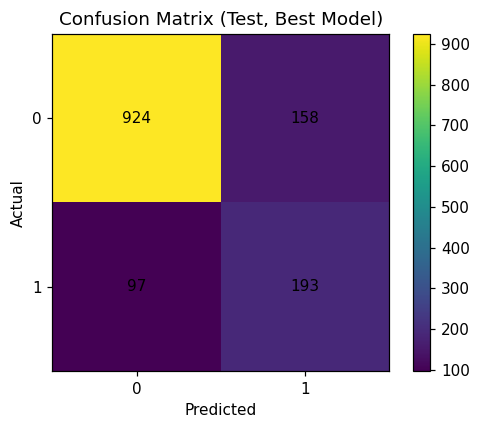

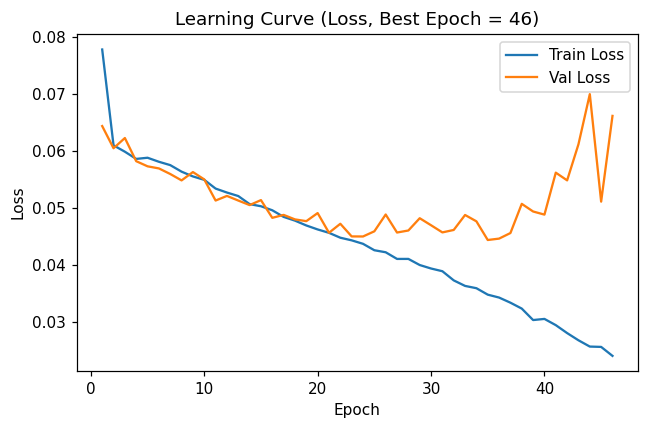

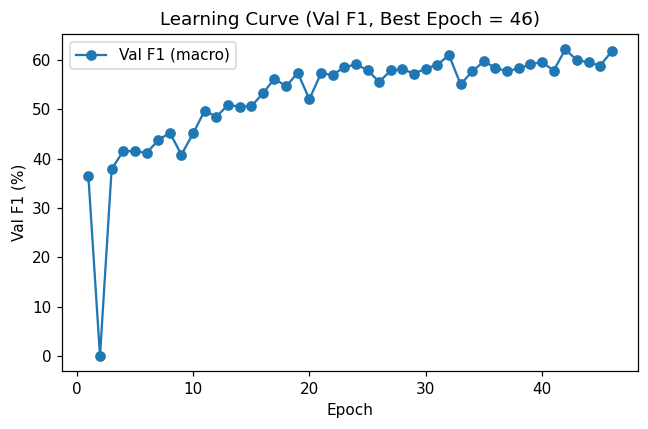

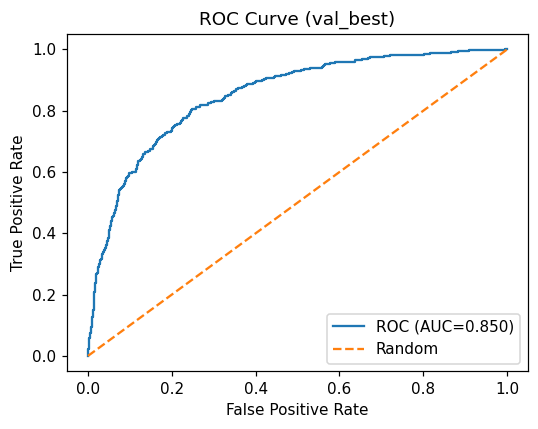

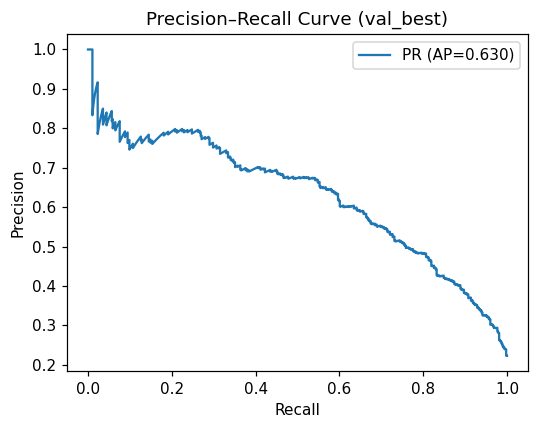

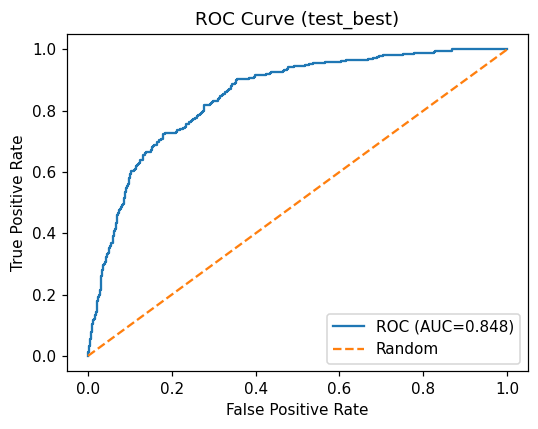

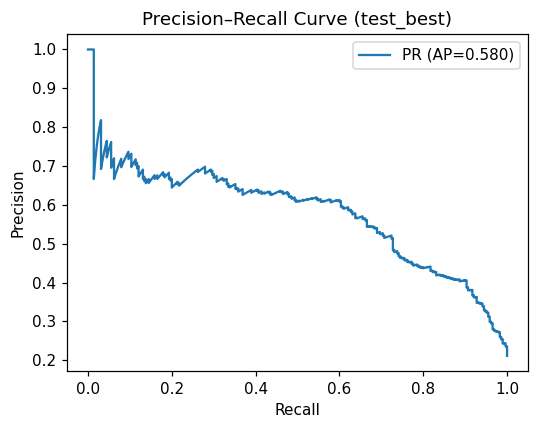

In [18]:
val_metrics_best, yv_best, pv_best, sv_best = evaluate(model, dl_val, device)
test_metrics_best, yt_best, pt_best, st_best = evaluate(model, dl_test, device)

val_pct = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal" 
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    """
    在给定 y_true, y_score 上扫描多个阈值，返回按 sort_by 指标排序的 DataFrame。
    默认按 F1 从高到低排序。
    """
    # 保证是一维向量
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        # 自己也可以改成 np.linspace(0.0, 1.0, 101)
        thresholds = np.linspace(0.05, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        # 打印成百分比方便对比
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

# ===== 1) 在验证集上扫阈值 =====
# 这里用你前面 evaluate 得到的 yv_best, sv_best
df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> 使用验证集上 F1 最优的阈值: best_t = {best_t:.3f}")

# ===== 2) 在测试集上用 best_t 重新计算指标 =====
yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

# 注意：ROC-AUC 和 PR-AUC 与阈值无关，直接用概率算即可
test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")



=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.500 81.686 57.770 66.387 61.779 86.076
    0.450 80.281 54.400 71.429 61.762 82.821
    0.400 78.454 51.146 75.000 60.818 79.445
    0.350 76.347 48.176 80.462 60.268 75.166
    0.550 82.295 60.338 60.084 60.211 88.668
    0.600 83.747 67.292 52.731 59.128 92.646
    0.300 72.740 44.098 83.193 57.642 69.741
    0.250 69.274 41.071 86.975 55.795 64.195
    0.200 64.637 37.774 90.546 53.309 57.203
    0.650 82.998 69.153 42.857 52.918 94.515

Best threshold on validation set (by f1):
t = 0.500, Acc=81.686%, Prec=57.770%, Rec=66.387%, F1=61.779%, Spec=86.076%

>>> 使用验证集上 F1 最优的阈值: best_t = 0.500

[Best threshold model @ Test (t=0.500)]
Accuracy (%)        : 81.414
Precision (%)       : 54.986
Recall (%)          : 66.552
F1-Score (%)        : 60.218
Specificity (%)     : 85.397
ROC-AUC (%)         : 84.820
Precision-recall (%): 57.985


In [19]:
import pandas as pd

rows = [
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)
df_best.to_csv(os.path.join(OUT_DIR, "best_val_test_metrics_convnextv2.csv"), index=False)


         Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0   Val (Best)        81.686         57.770      66.387        61.779   
1  Test (Best)        81.414         54.986      66.552        60.218   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           86.076       85.035                63.045  
1           85.397       84.820                57.985  
